In [1]:
import wandb
import equinox as eqx
import os 

# Foundational SSM imports
from omegaconf import OmegaConf
import tempfile 
from foundational_ssm.models import SSMDownstreamDecoder
from foundational_ssm.utils import h5_to_dict
from foundational_ssm.transform import smooth_spikes
import jax
import jax.numpy as jnp
import numpy as np
from typing import Any, BinaryIO


%load_ext autoreload
%autoreload 2

def default_deserialise_filter_spec(f: BinaryIO, x: Any) -> Any:
    """Default filter specification for deserialising saved data.

    **Arguments**

    -   `f`: file-like object
    -   `x`: The leaf for which the data needs to be loaded.

    **Returns**

    The new value for datatype `x`.

    !!! info

        This function can be extended to customise the deserialisation behaviour for
        leaves.

    !!! example

        Skipping loading of jax.Array.

        ```python
        import jax.numpy as jnp
        import equinox as eqx

        tree = (jnp.array([4,5,6]), [1,2,3])
        new_filter_spec = lambda f,x: (
            x if isinstance(x, jax.Array) else eqx.default_deserialise_filter_spec(f, x)
        )
        new_tree = eqx.tree_deserialise_leaves("some_filename.eqx", tree, filter_spec=new_filter_spec)
        ```
    """  # noqa: E501
    if isinstance(x, (jax.Array, jax.ShapeDtypeStruct)):
        return jnp.load(f)
    elif isinstance(x, np.ndarray):
        # Important to use `np` here to avoid promoting NumPy arrays to JAX.
        return np.load(f)
    elif eqx.is_array_like(x):
        # np.generic gets deserialised directly as an array, so convert back to a scalar
        # type here.
        # See also https://github.com/google/jax/issues/17858
        out = np.load(f)
        if isinstance(x, jax.dtypes.bfloat16):
            out = out.view(jax.dtypes.bfloat16)
        if np.size(out) == 1:
            return type(x)(out.item())
    else:
        return x

def load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMDownstreamDecoder):
    """Load model, optimizer state, epoch, and step from a checkpoint file."""
    api = wandb.Api()
    try:
        artifact = api.artifact(artifact_full_name, type="checkpoint")
    except Exception as e:
        raise FileNotFoundError(f"Could not find checkpoint artifact: {artifact_full_name}")
    
    run = artifact.logged_by()
    run_cfg = OmegaConf.create(run.config)
    model_cfg = OmegaConf.create(run_cfg.model)
    model_template, state_template = eqx.nn.make_with_state(model_cls)(
        **model_cfg,
    )
    
    with tempfile.TemporaryDirectory() as temp_dir:
        artifact.download(temp_dir)
        model = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "model.ckpt"), model_template, default_deserialise_filter_spec)
        state = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "state.ckpt"), state_template, default_deserialise_filter_spec)

    meta = artifact.metadata
    return model, state, meta

In [2]:
layer = "2"
pretrain_mode = "scratch"
train_mode = "freeze_a"
alias = "best" # can be latest/best/ epoch_{any value in range(0,1000,100)}
# epoch 0 now stores a fresh model.
artifact_full_name = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:{alias}"
model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name)

wandb:   3 of 3 files downloaded.  


In [3]:
# Download mc_rtt_trialized from https://huggingface.co/datasets/MelinaLaimon/nlb_processed/tree/main
# Edit dataset_dir to your directory
dataset_dir = "../../data/foundational_ssm/processed/nlb" 
dataset_path = os.path.join(dataset_dir, "mc_rtt_trialized.h5")
data = h5_to_dict(dataset_path)
data["neural_input"] = smooth_spikes(data["neural_input"], kern_sd_ms=20, bin_size_ms=5, time_axis=1)
input = data["neural_input"]
target_vel = data["behavior_input"]

# Specify the layers you want to generate the activations of. 
# ["post_encoder", "ssm_pre_activation", "ssm_post_activation"]
layer_keys = ["ssm_pre_activation"] 
inf_model = eqx.nn.inference_mode(model) # Switches off dropout
pred_vel, _, activations = jax.vmap(inf_model.call_with_activations, axis_name="batch", in_axes=(0, None, None))(input, state, layer_keys)

# Example: Plotting Output

In [39]:
import pandas as pd 
import matplotlib.pyplot as plt
trial_info = pd.read_csv(os.path.join(dataset_dir, "mc_rtt_trialized.csv"))
dt = 0.005  # or your actual timestep size
skip_timesteps = 56 
target_pos = np.cumsum(target_vel[:, skip_timesteps:, :] * dt, axis=1)
pred_pos = np.cumsum(pred_vel[:, skip_timesteps:, :] * dt, axis=1)
n_samples = pred_vel.shape[0]
n_train_samples = int(0.7 * n_samples)


bins = np.arange(0, 361, 30)
labels = [f"{i}-{i+30}" for i in bins[:-1]]
trial_info["angle_bin_label"] = pd.cut(trial_info["reach_angle"] % 360, bins=bins, labels=labels, right=False)
trial_info["split"] = ["train"] * n_train_samples + ["val"] * (n_samples - n_train_samples)

In [ ]:
from sklearn.metrics import r2_score
results = {
    'train': {
        'target_pos_mean': {},
        'target_pos_std': {},
        'pred_pos_mean': {},
        'pred_pos_std': {},
        'error': {},
        'r2': {}
    },
    'val': {
        'target_pos_mean': {},
        'target_pos_std': {},
        'pred_pos_mean': {},
        'pred_pos_std': {},
        'error': {},
        'r2': {}
    }
}

for angle_bin_label in trial_info['angle_bin_label'].unique():
    filter = trial_info[(trial_info['angle_bin_label'] == angle_bin_label) & (trial_info["split"].isin(["train"]))].index.values
    results['train']['target_pos_mean'][angle_bin_label] = np.mean(target_pos[filter], axis=0)
    results['train']['target_pos_std'][angle_bin_label] = np.std(target_pos[filter], axis=0)
    results['train']['pred_pos_mean'][angle_bin_label] = np.mean(pred_pos[filter], axis=0)
    results['train']['pred_pos_std'][angle_bin_label] = np.std(pred_pos[filter], axis=0)
    results['train']['error'][angle_bin_label] = np.std(target_pos[filter] - pred_pos[filter], axis=0)
    results['train']['r2'][angle_bin_label] = r2_score(target_pos[filter].reshape(-1, 2), pred_pos[filter].reshape(-1, 2))

    filter = trial_info[(trial_info['angle_bin_label'] == angle_bin_label) & (trial_info["split"].isin(["val"]))].index.values
    results['val']['target_pos_mean'][angle_bin_label] = np.mean(target_pos[filter], axis=0)
    results['val']['target_pos_std'][angle_bin_label] = np.std(target_pos[filter], axis=0)
    results['val']['pred_pos_mean'][angle_bin_label] = np.mean(pred_pos[filter], axis=0)
    results['val']['pred_pos_std'][angle_bin_label] = np.std(pred_pos[filter], axis=0)
    results['val']['error'][angle_bin_label] = np.std(target_pos[filter] - pred_pos[filter], axis=0)
    results['val']['r2'][angle_bin_label] = r2_score(target_pos[filter].reshape(-1, 2), pred_pos[filter].reshape(-1, 2))


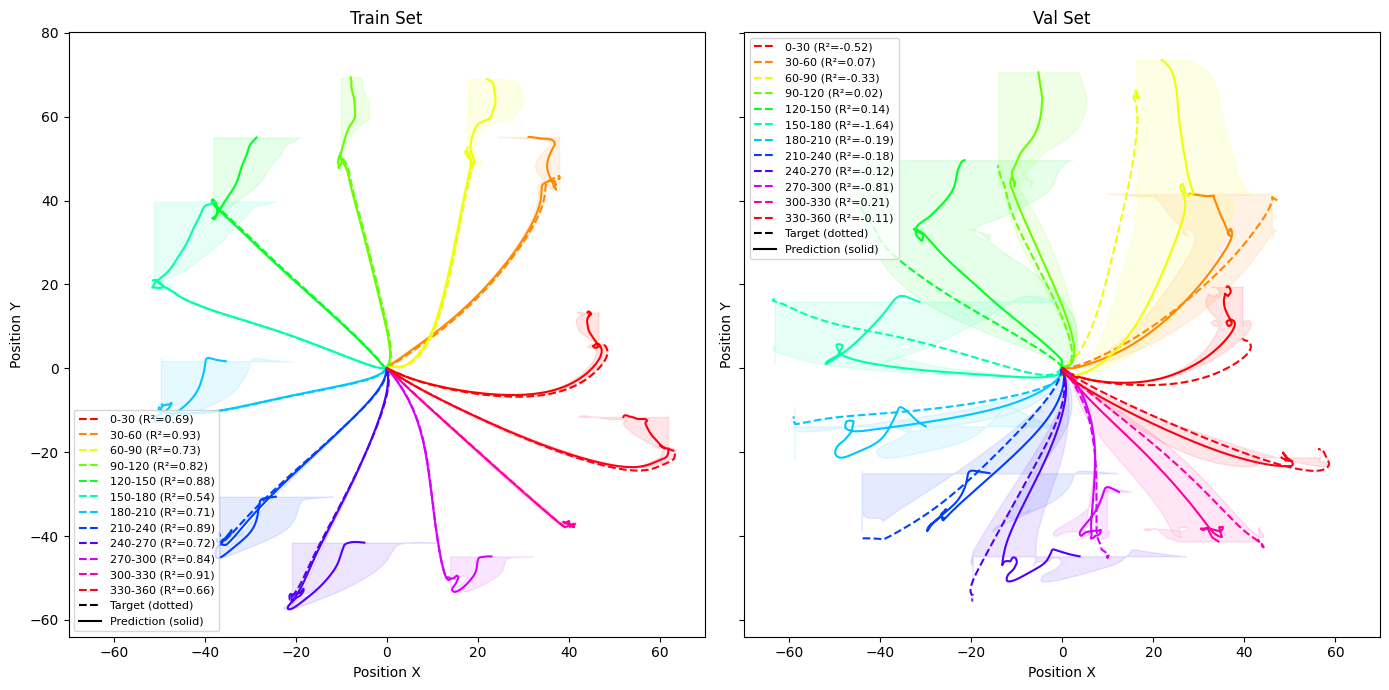

In [65]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)
splits = ['train', 'val']
colors = plt.cm.hsv(np.linspace(0, 1, len(labels)))

for i, split in enumerate(splits):
    ax = axs[i]
    for j, angle_bin_label in enumerate(labels):
        target_mean = results[split]['target_pos_mean'][angle_bin_label]
        target_std = results[split]['target_pos_std'][angle_bin_label]
        pred_mean = results[split]['pred_pos_mean'][angle_bin_label]
        error = results[split]['error'][angle_bin_label]

        # Only add label for angle bins on target line
        r2_val = results[split]['r2'][angle_bin_label]
        ax.plot(target_mean[:, 0], target_mean[:, 1], linestyle='--', color=colors[j], label=f'{angle_bin_label} (R²={r2_val:.2f})')
        ax.plot(pred_mean[:, 0], pred_mean[:, 1], linestyle='-', color=colors[j])
        

        # ax.fill_betweenx(
        #     target_mean[:, 1],
        #     target_mean[:, 0] - target_std[:, 0],
        #     target_mean[:, 0] + target_std[:, 0],
        #     color=colors[j], alpha=0.1
        # )
        ax.fill_betweenx(
            pred_mean[:, 1],
            pred_mean[:, 0] - error[:, 0],
            pred_mean[:, 0] + error[:, 0],
            color=colors[j], alpha=0.1
        )

    ax.set_title(f"{split.capitalize()} Set")
    ax.set_xlabel("Position X")
    ax.set_ylabel("Position Y")

    # Custom legend for line styles
    handles, labels_ = ax.get_legend_handles_labels()
    custom_lines = [
        Line2D([0], [0], color='black', linestyle='--', label='Target (dotted)'),
        Line2D([0], [0], color='black', linestyle='-', label='Prediction (solid)')
    ]
    ax.legend(handles=handles + custom_lines, fontsize=8, loc='best')

plt.tight_layout()
plt.show()

In [66]:
trial_info['pos'] = trial_info[['start_pos', 'target_pos']].apply(tuple, axis=1)
trial_agg_angle_summary = (
    trial_info
    .groupby(['split', 'angle_bin_label'])
    .agg(
        count=('trial_id', 'count'),
        unique_pos=('pos', 'nunique'),
        total_duration=('duration', 'sum')
    )
    .reset_index()
)
trial_agg_angle_summary['r2'] = trial_agg_angle_summary.apply(lambda row: results[row['split']]['r2'].get(row['angle_bin_label'], np.nan), axis=1)
trial_agg_angle_summary

/tmp/ipykernel_49323/1742907215.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['split', 'angle_bin_label'])


,split,angle_bin_label,count,unique_pos,total_duration,r2
0,train,0-30,36,35,41.276,0.685391
1,train,30-60,28,27,37.544,0.927879
2,train,60-90,20,19,23.152,0.727183
3,train,90-120,48,41,57.192,0.815584
4,train,120-150,31,30,39.564,0.875141
5,train,150-180,24,21,29.960,0.539635
6,train,180-210,36,33,42.260,0.706583
7,train,210-240,35,33,44.256,0.888582
8,train,240-270,20,19,22.836,0.723907
9,train,270-300,50,45,55.556,0.841303
